## Imports and Dependencies

In [1]:
from simple_deep_learning.mnist_extended.semantic_segmentation import create_semantic_segmentation_dataset
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import matplotlib
from matplotlib import pyplot as plt
from torchmetrics import Accuracy, Precision, Recall
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import normalize
from torch.utils.tensorboard import SummaryWriter

### Reload and Clear GPU Cache

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()
# CUDA_LAUNCH_BLOCKING=1

%load_ext autoreload
%autoreload 2

## Model Definitions and helper classes

### Example ConvNet Model (from example)

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ConvNet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        return x

### U-Net and Helper Classes for Normalized ReLU and Dice Loss

In [4]:
from unet_model import UNet

class NormalizedReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
    def forward(self, x):
        relu_output = self.relu(x)
        max_value = torch.max(relu_output)
        
        if max_value != 0:
            normalized_output = relu_output / max_value
        else:
            normalized_output = torch.zeros_like(relu_output)
        
        return normalized_output

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, y_true, y_pred):
        batch_size = y_true.size(0)
        sum_dim = (-1, -2, -3)
        inter = 2 * (y_true * y_pred).sum(dim=sum_dim)
        sets_sum = y_pred.sum(dim=sum_dim) + y_true.sum(dim=sum_dim)
        sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

        dice = (inter + self.smooth) / (sets_sum + self.smooth)
        return 1-dice.mean()
        

### Pytorch Lightning Module
Define which model will be initialized, which loss function will be used and implement forward function, training/val step and optimizer

In [5]:
# Create a PyTorch Lightning module
class UNetModule(pl.LightningModule):
    def __init__(self, num_classes = 10, learning_rate=1e-5, weight_decay = 1e-8):
        super().__init__()
        #self.model = ConvNet((1,60,60), 3)
        self.model = UNet(1, num_classes)
        #self.loss_fn_2 = DiceLoss()
        self.loss_fn = nn.MSELoss()
        #self.loss_fn = nn.BCEWithLogitsLoss()
        self.normalized_relu = NormalizedReLU()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        #self.accuracy = Accuracy('multiclass', num_classes=3, multidim_average="samplewise")
        # self.precision = BinaryPrecision()
        #self.recall = BinaryRecall()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #loss = self.loss_fn(y_hat, y)
        #y_hat = F.sigmoid(y_hat)
        y_hat = self.normalized_relu(y_hat)
        #loss = self.loss_fn_2(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #loss = self.loss_fn(y_hat, y)
        y_hat = self.normalized_relu(y_hat)
        #y_hat = F.sigmoid(y_hat)
        loss = self.loss_fn(y_hat, y)
        #loss = self.loss_fn_2(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

        y_hat_flat_rounded = y_hat.view(-1).round()
        #y_hat_flat_rounded = F.sigmoid(y_hat).view(-1).round()
        #y_hat_flat_rounded = F.sigmoid(y_hat).view(-1)
        y_flat = y.view(-1)

        acc = (y_hat_flat_rounded == y_flat).float().sum()/torch.numel(y_flat) * 100
        self.log('val_acc', acc, prog_bar=True)

        true_positive = torch.sum((y_hat_flat_rounded != 0) & (y_flat != 0))
        total_positive = torch.sum(y_flat != 0)
        recall = true_positive.float() / total_positive.float()
        self.log('val_rec', recall, prog_bar=True)

        false_positive = torch.sum((y_hat_flat_rounded != 0) & (y_flat == 0))
        precision = true_positive / (true_positive + false_positive + 1e-7)  # Add a small epsilon to avoid division by zero
        self.log('val_prec', precision, prog_bar=True)
        
        #rec = self.recall(y_hat.view(-1,1), y.view(-1,1))
        #self.log('val_rec', rec, prog_bar=True)
        #self.accuracy(y_hat, y)
        # self.precision(y_hat, y)
        #print(f"shapes: {y_hat.view(-1).shape},  {y.view(-1).shape}")
        #self.recall(y_hat.view(-1), y.view(-1))
    
    # def on_validation_epoch_end(self, outputs):
    #     self.log('val_accuracy', self.accuracy.compute())
    #     self.log('val_precision', self.precision.compute())
    #     self.log('val_recall', self.recall.compute())
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

## Dataset Preparation


### Create Semantic Segmentation Dataset
Load data, convert to tensors and make dimensions right (B, C, H, W)

In [6]:
num_train_samples=1000
num_test_samples = 200
num_classes=10
np.random.seed(1)
train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(num_train_samples=num_train_samples,
                                                                        num_test_samples=num_test_samples,
                                                                        image_shape=(60, 60),
                                                                        max_num_digits_per_image=4,
                                                                        num_classes=num_classes)
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

test_y = test_y.permute(0, 3, 1, 2)
train_x = train_x.squeeze(-1).unsqueeze(1)
train_y = train_y.permute(0, 3, 1, 2)
test_x = test_x.squeeze(-1).unsqueeze(1)

c:\Users\DELL\Documents\interview_homework\simple_deep_learning\mnist_extended\mnist.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  images = images[valid_examples]
c:\Users\DELL\Documents\interview_homework\simple_deep_learning\mnist_extended\mnist.py:62: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  labels = labels[valid_examples]


### Visualize Example Datapoint

torch.Size([1000, 1, 60, 60]) torch.Size([1000, 10, 60, 60])


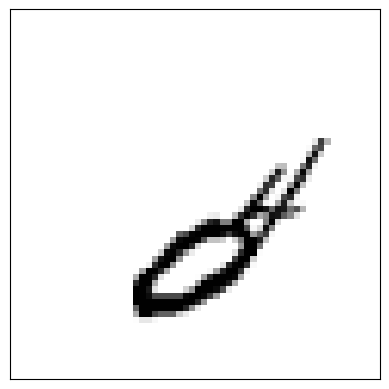

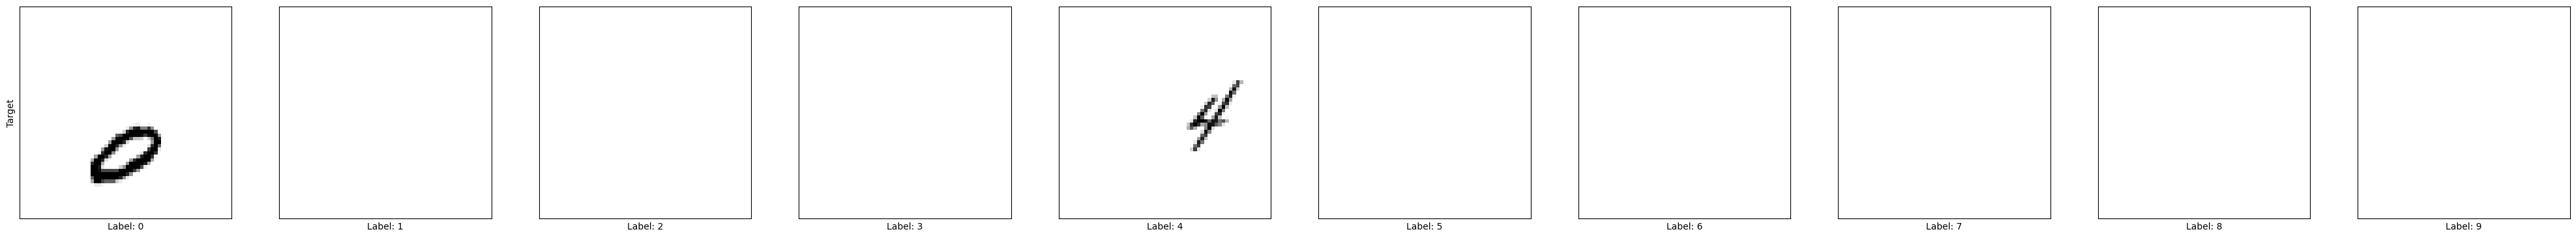

In [7]:
import numpy as np
from simple_deep_learning.mnist_extended.semantic_segmentation import display_grayscale_array, plot_class_masks

print(train_x.shape, train_y.shape)

i = np.random.randint(len(train_x))
display_grayscale_array(array=train_x[i])

plot_class_masks(train_y[i])

### Create Dataloader

In [8]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Model Initialization and Training

### Initiate Trainer and Model

In [50]:
writer = SummaryWriter()
trainer = pl.Trainer(
    max_epochs=60,
    logger=pl.loggers.TensorBoardLogger('logs/', name='unet'),
    callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=10),
               EarlyStopping(monitor="val_loss", min_delta=0.00, patience=4, verbose=False, mode="min"),
               ModelCheckpoint("./checkpoints/", monitor="val_loss", save_top_k=1, filename='semseg_unet_mse_10-{epoch:02d}-{val_loss:.4f}'),
               LearningRateMonitor("epoch")],
)
model = UNetModule(num_classes= 10, learning_rate=5e-4, weight_decay = 1e-6)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Check Model Architecture

In [41]:
model

UNetModule(
  (model): UNet(
    (sigmoid): Sigmoid()
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            

### Train Model

In [51]:
trainer.fit(model, train_loader, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | model           | UNet           | 31.0 M
1 | loss_fn         | MSELoss        | 0     
2 | normalized_relu | NormalizedReLU | 0     
---------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.148   Total estimated model params size (MB)


Epoch 29: 100%|██████████| 1875/1875 [02:14<00:00, 13.95it/s, v_num=25, train_loss=6.24e-5, val_loss=0.000195, val_acc=98.20, val_rec=0.687, val_prec=0.992] 


## Qualitative Analysis


### Load model from checkpoint if neccessary

In [10]:
#device = torch.device('cpu')
model = UNetModule.load_from_checkpoint(checkpoint_path="./checkpoints/semseg_unet_mse-epoch=01+11-val_loss=0.0001.ckpt")
#model.to(device)

### Predict test set with current model

In [11]:
test_y_predicted = model(test_x.cuda())

### Convert logit values to 0-1 range if neccessary

In [12]:
nr = NormalizedReLU()
test_y_predicted_norm = nr(test_y_predicted)
#test_y_predicted_norm = F.sigmoid(test_y_predicted)

### Visualize Examples

Example 138


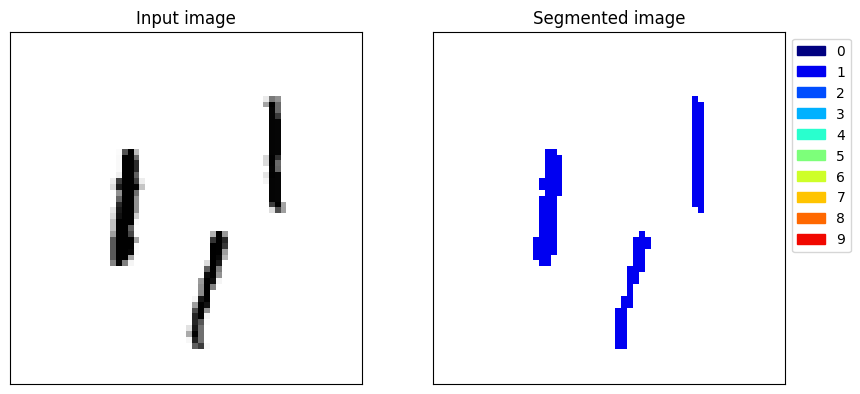

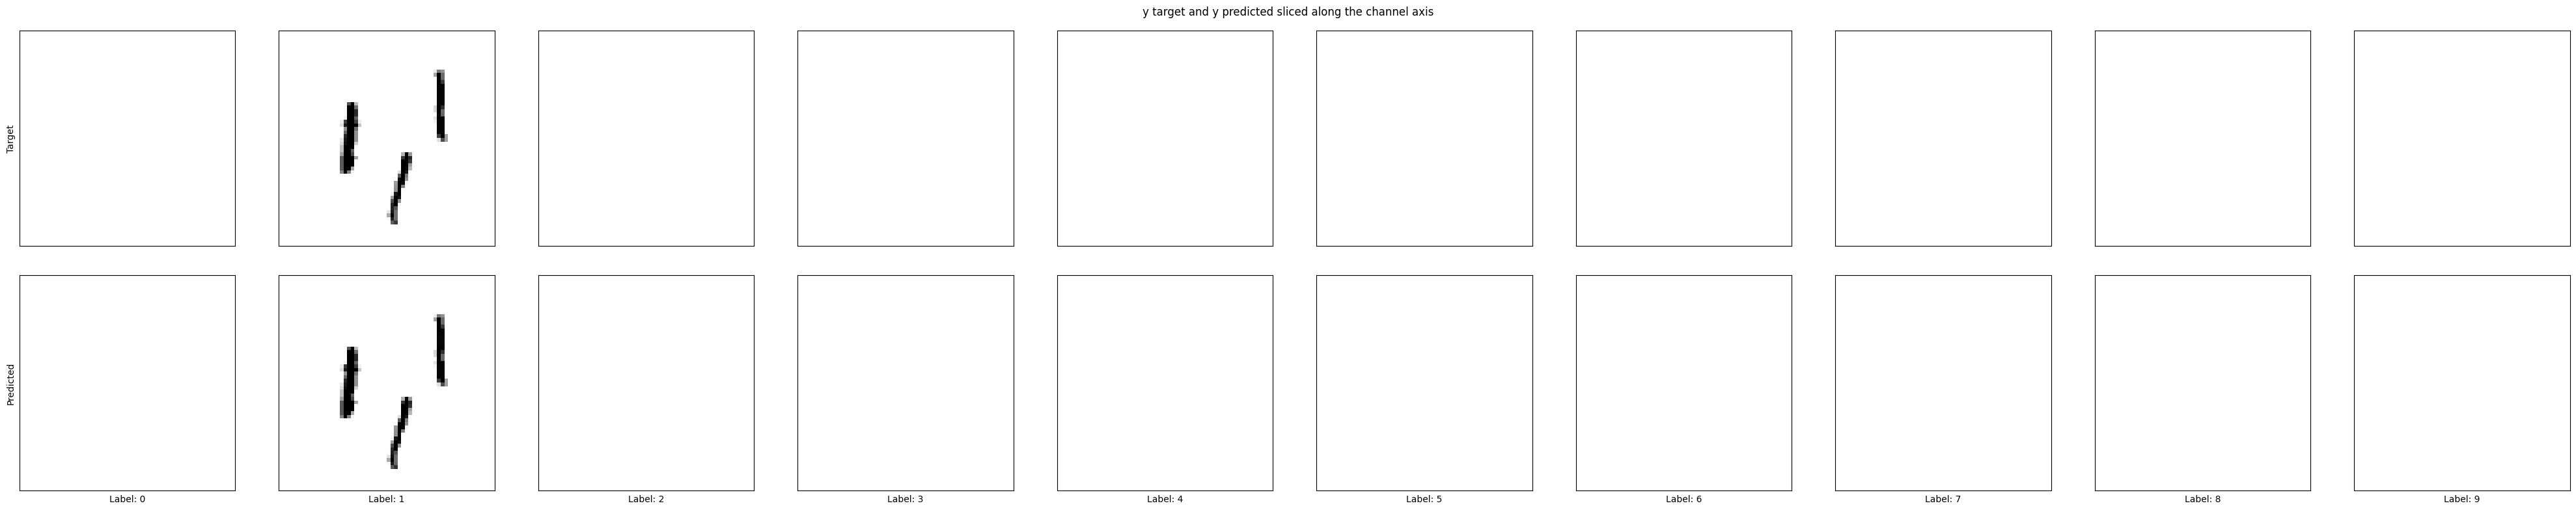

Example 106


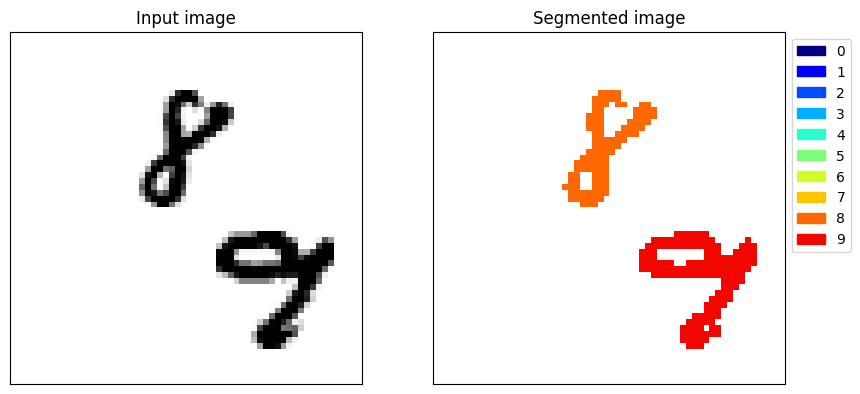

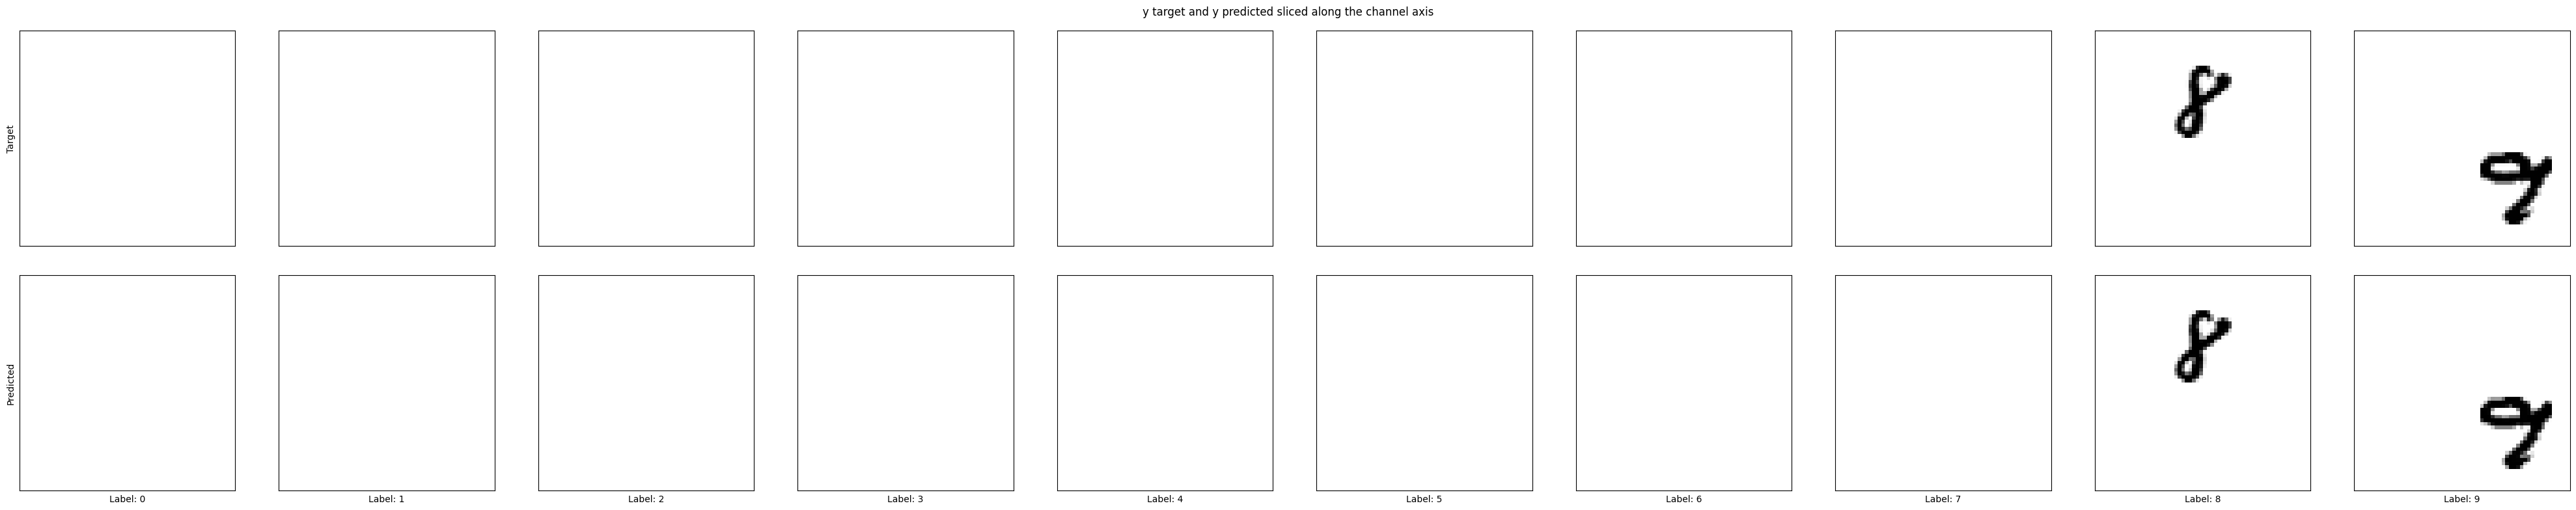

Example 109


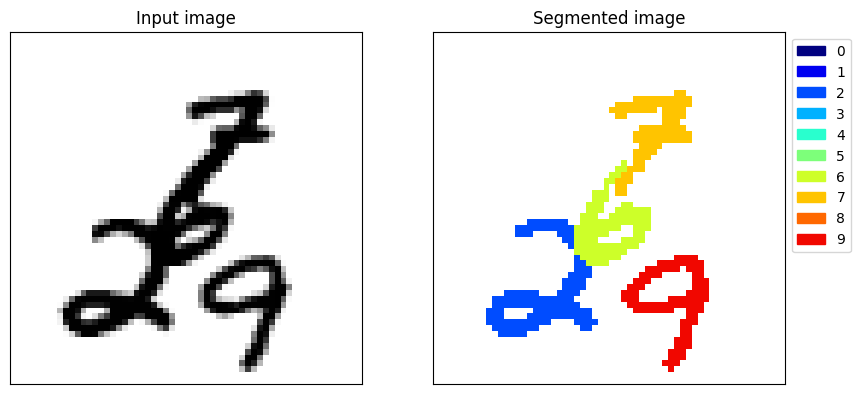

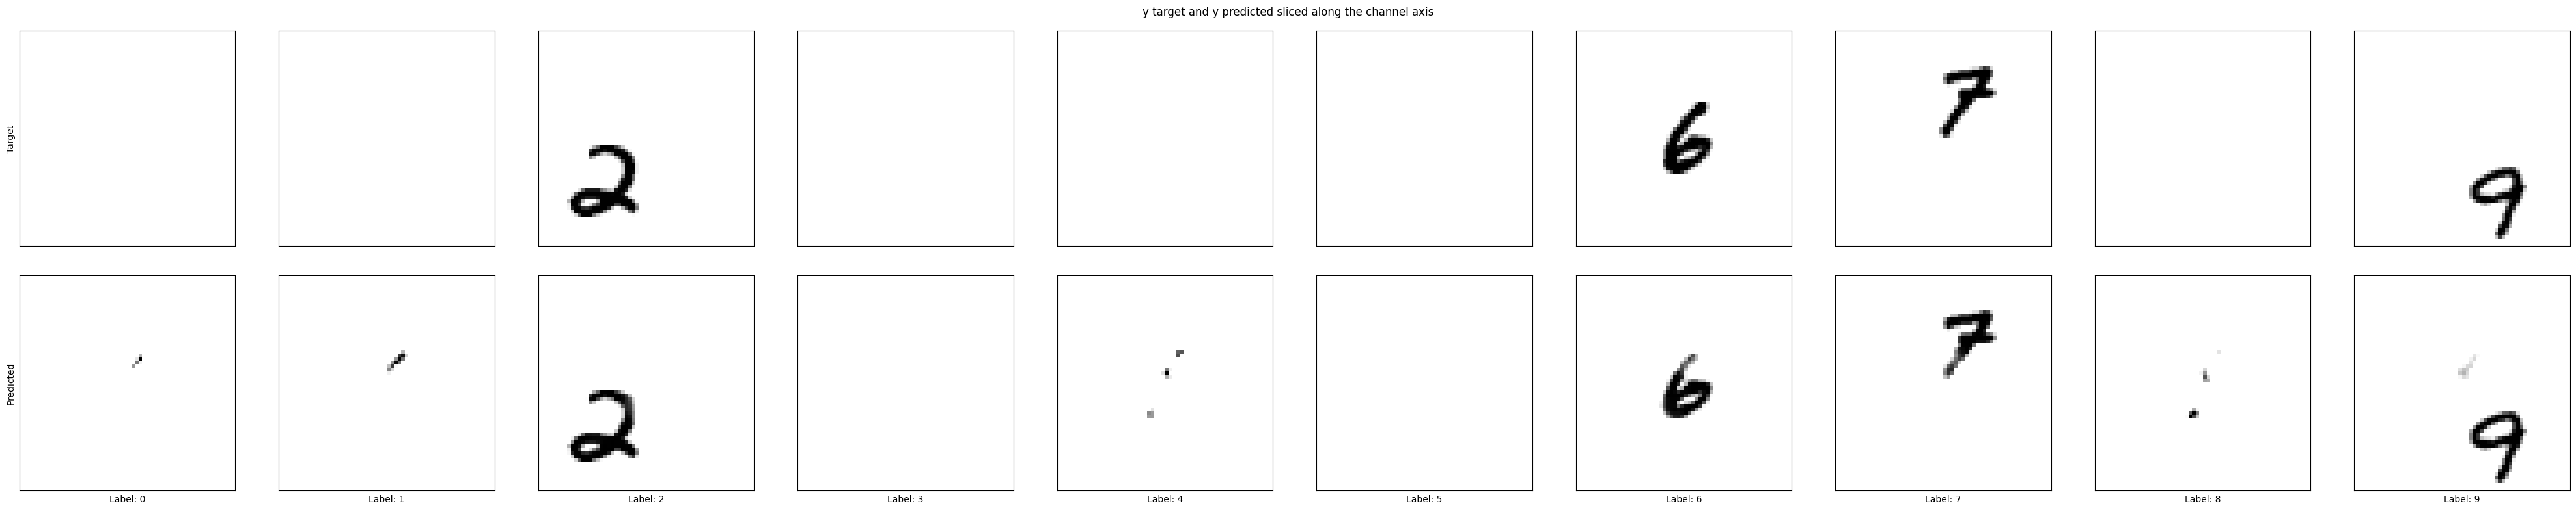

In [13]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image

np.random.seed(6)
for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    i = np.random.randint(len(test_y_predicted_norm.cpu()))
    print(f'Example {i}')
    display_grayscale_array(test_x[i].cpu(), ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted_norm[i].cpu(), ax=ax2, title='Segmented image')
    plot_class_masks(test_y[i].cpu(), test_y_predicted_norm[i].cpu(), title='y target and y predicted sliced along the channel axis')